---
title: "Reciever calibration"
bibliography: ../bibliography.bib
---


# Reciever calibration

In this tutorial, I will briefly discuss the issue of calibrating GNSS receivers for TEC measurement. Several interesting scientific articles have been devoted to this topic, which I recommend reading for a full understanding of the subject [@Sardon1994; @Arikan2008]. Let's start by writing down the observation equations for code observations at two frequencies.


$P_1 = \rho + c(\delta t_r - \delta t_s) + T + I_1 + b^{P}_{r,1} + b^{P}_{s,1} + \varepsilon_{P_1} \space [m]$

$P_2 = \rho + c(\delta t_r - \delta t_s) + T + I_2 + b^{P}_{r,2} + b^{P}_{s,2} + \varepsilon_{P_2} \space [m]$

$P_{\mathrm{GF}} = P_1 - P_2 = (I_1 - I_2) + (b^{P}_{r,1}-b^{P}_{r,2}) + (b^{P}_{s,1}-b^{P}_{s,2}) + (\varepsilon_{P_1}-\varepsilon_{P_2}) \space [m]$

where:

- $P_1$ - code observation on frequency 1
- $P_2$ - code observation on frequency 2
- $P_{\mathrm{GF}}$ - geometry-free combination of $P_1$ and $P_2$
- $I_n$ - ionospheric delay in meters of $n$ frequency
- $b^{P}_{r,n}, \space b^{P}_{s,n} $ - reciever and satellite hardware delay for signals at frequency $n$


During global ionosphere maps generation process, receiver and satellite biases are elements of the state vector. Therefore, as I mentioned in the previous chapter, we have access to satellite and receiver biases in the IONEX file header. These are the biases of the satellites and receivers that were obtained during map generation process. On various data servers, you will also find SINEX files with the .BSX or .BIA extension, which contain DSB or OSB bias values for satellites and some recievers [@SINEXBIAS]. What interests us is the bias for geometry-free observations. It is necessary to have it, because without it, we obtain a STEC value that is subject to systematic error. The process of determining the receiver bias is called receiver calibration (not to be confused with PCO/PCV determination, which is called the same). In GNX-py, the receiver bias is determined in two ways, both of which depend directly on the ionosphere model used:

1) Calibration using the weighted average method

2) Calibration using PPP-UDUC


Both methods can be summarised as follows: it is the levelling of the measured STEC to the modelled STEC. In this sense, the process is somewhat similar to the phase to code levelling mentioned in the previous chapter.  In the weighted average method, after correcting the levelled GF observations (in metres) for satellite bias converted from nanoseconds to metres, we differentiate between the modelled and calculated delay for satellites observed above a certain elevation angle (60 degrees by default). These differences are then averaged over time and weighted by elevation angle, thus obtaining a single estimate for a given timestep. Next, we apply the median function to the set of these values to obtain the final DCB estimate for the receiver. In the PPP-UDUC method, hardware delays of undifferentiated observations are part of the state vector. In fact, in this method, we directly estimate DCB, because GNX-py uses the method of ‘freezing’ the OSB bias of observations at one of the frequencies (L1 and E1 for GPS and Galileo) by default. In this way, we obtain DCB estimates for each of the epochs processed in the filter. In the software folder, you will find the $ppp2dsb.py$ script, which processes the PPP processing output files and generates a CSV file with DCB values for stations for which results are located in the specified directory. You can pass DCBs contained in it to the configuration class, and then it will be used in the STEC measurement. I mentioned earlier that both methods depend on the ionosphere model used, and I would like to return to this point here. You have probably already noticed that the first method is actually a brute-force fit of the measurements to the modelled value. Thus, the quality of the background model value directly affects the DCB value. I recommend using GIM models rather than NTCM or Klobuchar for calibration, as this allows us to fit to the best quality model.  This, of course, makes our measurements extremely dependent on the availability of GIM, but at the current stage of software development, it is the best intermediate step we can take. At first glance, it may seem that PPP-UDUC is less dependent on the model used as ionospheric constraints. After all, the influence of a priori ionospheric observations is gradually reduced in the filter. However, as we will show below, the differences in the determined DCBs are quite significant.

Let us now move on to specific examples. We will build an instance of the configuration class that is almost identical to the one in the Introduction, setting only the $rcv\_dcb\_source$ parameter to $calibrate$. This way, the TECSession class will run the calibration procedure. We choose GIM as the background model, as we want to compare the calibrated DCB with the one obtained in GIM. The BOR1 station was chosen because it belongs to the stations used to generate GIM.

In [1]:
import gps_lib as gnx
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)
np.set_printoptions(threshold=np.inf, linewidth=200, suppress=True, precision=3)


In [2]:
OBS_PATH='../data/BOR100POL_R_20240350000_01D_30S_MO.rnx'
NAME = OBS_PATH.split('/')[-1][:4]


NAV = '../data/BRDC00IGS_R_20240350000_01D_MN.rnx'
SP3_LIST=[
'../data/COD0OPSFIN_20240340000_01D_05M_ORB.SP3',
'../data/COD0OPSFIN_20240350000_01D_05M_ORB.SP3',
'../data/COD0OPSFIN_20240360000_01D_05M_ORB.SP3']
ATX_PATH='../data/ngs20.atx'
DCB_PATH= '../data/COD0OPSFIN_20240350000_01D_01D_OSB.BIA'
GIM='../data/COD0OPSFIN_20240350000_01D_01H_GIM.INX'
TLIM = [datetime(2024,2,4,0,0,0),
        datetime(2024,2,4,23,59,30)]

SYS= 'G'

DOY=35
C=299792458

In [3]:
config = gnx.TECConfig(obs_path=OBS_PATH,
                                       nav_path=NAV,
                                       sp3_path=SP3_LIST,
                                       gim_path=GIM,
                                       sys="G",
                                       gps_freq='L1L2',
                                       gal_freq='E1E5a',
                                       windup=False,
                                       rel_path=False,
                                       sat_pco=True,
                                       rec_pco=True,
                                       atx_path=ATX_PATH,
                                       interpolation_method='lagrange',
                                       ev_mask=30,

                                       add_dcb=True,
                                       add_sta_dcb=True,

                                       rcv_dcb_source='calibrate',

                                       screen=True,
                                       # skip_sat=['G20','G02'],

                                       station_name=NAME,
                                       day_of_year=DOY,

                                       ionosphere_model='gim',
                                       compare_models=False,
                                       troposphere_model=False,
                                       use_gfz=True,
                                       leveling_ws=50,
                                       median_leveling_ws=50,
                                       min_arc_len=2
                                       )

In [4]:
controller = gnx.TECSession(config=config)
obs_tec = controller.run()

When reading the IONEX file, software also loads the DCB by default. If the station has a DCB defined in the IONEX file header, it will be placed in the dataframe in the $sta\_bias$ column. This gives us access to the calibrated and reference DCB. The calibrated DCB was, of course, used in the STEC calculations.

In [5]:
ref_bias = obs_tec['sta_bias'].iloc[0]
calibrated = obs_tec['sta_dcb'].iloc[0]

In [6]:
bias_error = (ref_bias-calibrated)
print(f"Calibration error for station {NAME}: {bias_error:.3f} [ns]  (Weighted average method)")

Calibration error for station BOR1: 0.281 [ns]  (Weighted average method)


We obtained an error of 0.2 nanoseconds. We can safely assume that an error below 1 nanosecond is expected and acceptable for such a simple calibration method (X,Y,Z). Now let's compare the DCB obtained using the PPP-UDUC method. To do this, let's load the data we processed while working with the PPP guide.

In [7]:
sol = pd.read_csv('../output/unc_sol.csv')

As I mentioned in PPP-UDUC, we freeze the OSB bias for the reference frequency, thereby forcing the OSB estimation for the second frequency  in a differentiated form - DSB, which is exactly what we are interested in. As a result of the equations in the PPP method, we obtain this estimate with the opposite sign. Let us now compare the DCB value from the last filtration epoch and the average from all epochs after the 120th. The value 120, corresponding to 2 hours assuming a 30-second sampling rate, is chosen because even for a ‘problematic’ station, after 2 hours we are almost certain to achieve filter stabilization. The reason why it shows these two values is that the ppp2dsb script returns precisely these two values.

In [8]:
ppp_dcb = -sol['dcb_gps_c2']/C/1e-09

In [9]:
last_ep = ppp_dcb.iloc[-1]

In [10]:
mn = ppp_dcb.iloc[120:].mean()


In [11]:
d1 = ref_bias-last_ep
d2 = ref_bias-mn

In [12]:
print(f"Calibration error for station {NAME}: {d1:.3f},{d2:.3f} [ns]  (PPP-UDUC)")

Calibration error for station BOR1: -0.436,-0.117 [ns]  (PPP-UDUC)


We see that last epoch DCB has a greater error than the one obtained in moving average approach, but mean DCB is around 10 ns closer to the reference. Let's now make a small comparison and perform STEC calculations for our DCBs with PPP and for those from the GIM file. The application of your own defined bias is done by configuring the appropriate fields in the control class:

In [13]:
config.rcv_dcb_source ='defined'
config.define_station_dcb = mn
controller = gnx.TECSession(config=config)
obs_tec_ppp = controller.run()

In [14]:
config.rcv_dcb_source ='gim'
controller = gnx.TECSession(config=config)
obs_tec_gim = controller.run()

We convert the obtained STEC into TECU units. Let us compare the observations obtained in the graph.

In [15]:
stec_calibrated = obs_tec[['leveled_tec']]/1e16
stec_ppp = obs_tec_ppp[['leveled_tec']]/1e16
stec_gim = obs_tec_gim[['leveled_tec']]/1e16

Let's write some simple code to visualise STEC on a shared graph. We will mark the STEC obtained from three sources on it so that we can see the DCB effect with our own eyes.

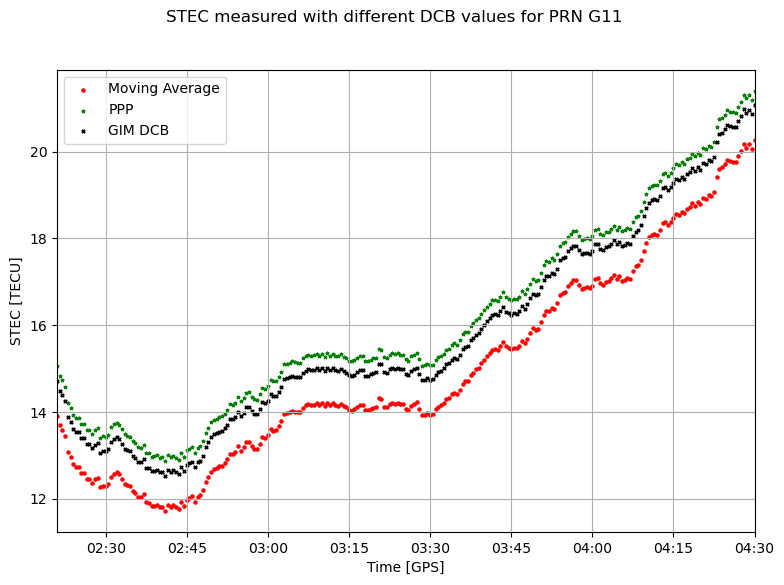

In [16]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

ind = 'G11_0_1'
fig, ax = plt.subplots(figsize=(9,6))
fig.suptitle(f"STEC measured with different DCB values for PRN {ind[:3]}")
gr = stec_calibrated.loc[ind]
ppp=stec_ppp.loc[ind]
gim = stec_gim.loc[ind]
gr=gr.reset_index()
gim=gim.reset_index()
ppp=ppp.reset_index()
ax.scatter(gr['time'],gr['leveled_tec'],label='Moving Average',s=5,c='r',marker='o')
ax.scatter(ppp['time'],ppp['leveled_tec'],label='PPP',s=5,c='g',marker='*')
ax.scatter(gim['time'],gim['leveled_tec'],label='GIM DCB',s=5,c='black',marker='x')
ax.set_xlim(gr['time'].min(),gr['time'].max())
ax.set_ylabel('STEC [TECU]')
ax.set_xlabel('Time [GPS]')
ax.grid()
ax.legend()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

In [17]:
print(f"Calibration error between GIM and PPP: {(stec_gim-stec_ppp)['leveled_tec'].round(3).unique()[0]} [TECU]")
print(f"Calibration error between GIM and Moving Average: {(stec_gim-stec_calibrated)['leveled_tec'].round(3).unique()[0]} [TECU]")


Calibration error between GIM and PPP: -0.334 [TECU]
Calibration error between GIM and Moving Average: 0.803 [TECU]


As you can see, the differences in DCB are quite significant. The receiver bias derived from the PPP solution turns out to be much closer to the reference than the one calibrated using the moving average method. In PPP-UDUC, we estimate it together with the ionospheric delay and the receiver clock, so it is a more advanced method than simple levelling of observations. For STEC measurements, which we discussed in the previous tutorial, the safest calibration method will be to first perform PPP with ionospheric constraints from the GIM model and then use the estimated DCB for STEC measurements.

Of course, both of these methods make us completely dependent on the availability of the model. In the future, the Ionosphere module will be developed with ionosphere modelling techniques that take into account the estimation of receiver DCBs. The PPP-UDUC technique presented here allows receivers to be calibrated with sufficient accuracy to perform STEC measurements and ensure that the DCB error does not exceed 1-2 TECU. In the next notebooks, we will present the programme's functionality that enables the calculation of ionosphere acitvity indexes. For some of them, proper DCB estimation plays a crucial role.